In [1]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])       

import_or_install('tensorflow')
import_or_install('pydot')


2023-11-15 13:07:23.327126: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 13:07:23.345292: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 13:07:23.345311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 13:07:23.345323: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 13:07:23.348893: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 13:07:23.349557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [5]:
import tensorflow as tf

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout 

In [6]:
import source.plots as plots

In [7]:
try:
    data
    print('data already loaded in parent notebook')
except NameError:
    data = np.load('data/feature_extract_reshaped.npy')
data.shape

(2387, 30, 63)

In [1281]:
import numpy as np

def split_data(data, test_size=0.2, val_size=0.2, random_state=None):
    # Assuming the first column contains the IDs
    ids_column = data[:, 0, 0]

    # Find unique epoch IDs
    unique_epoch_ids = np.unique(ids_column)

    # Shuffle the unique epoch IDs
    np.random.shuffle(unique_epoch_ids)

    # Calculate the number of unique epoch IDs for training, validation, and testing
    train_samples_nr = int(np.floor(0.8 * len(unique_epoch_ids)))

    # Split the unique epoch IDs into train, validation, and test sets

    train_sample_ids = unique_epoch_ids[:train_samples_nr]
    test_sample_ids = unique_epoch_ids[train_samples_nr:]

    # Create boolean masks for filtering
    train_mask = np.in1d(ids_column, train_sample_ids)
    test_mask = np.in1d(ids_column, test_sample_ids)

    # Apply the masks to create train, validation, and test samples
    train_sample = data[train_mask, :, :]
    test_sample = data[test_mask, :, :]

    X_train = train_sample[:,:,:-1]
    X_test = test_sample[:,:,:-1]

    Y_train = train_sample[:,:,-1]
    Y_test = test_sample[:,:,-1]

    y_test=Y_test.max(axis=1)
    y_train=Y_train.max(axis=1)

    return X_train, X_test, Y_train, Y_test, y_train, y_test


In [1282]:
X_train, X_test, Y_train, Y_test, y_train, y_test = split_data(data)
print(f'train shape', X_train.shape)
print(f'test shape', X_test.shape)

train shape (10664, 30, 62)
test shape (2666, 30, 62)


In [1283]:
# Scaling features
num_features_train = X_train[:,:,2:]
num_features_test = X_test[:,:,2:]

# Get the dimensions of the original array
num_epochs_tr, num_segments_per_epoch_tr, features_tr = num_features_train.shape
num_epochs_te, num_segments_per_epoch_te, features_te = num_features_test.shape

# Reshape the array to 2D
reshaped_array_train = num_features_train.reshape(num_epochs_tr * num_segments_per_epoch_tr, features_tr)
reshaped_array_test = num_features_test.reshape(num_epochs_te * num_segments_per_epoch_te, features_te)

# Scaling features
scaler = StandardScaler()
num_features_scaled_tr = scaler.fit_transform(reshaped_array_train)
num_features_scaled_te = scaler.transform(reshaped_array_test)

X_train_scaled = num_features_scaled_tr.reshape(num_epochs_tr, num_segments_per_epoch_tr, features_tr)
X_test_scaled = num_features_scaled_te.reshape(num_epochs_te, num_segments_per_epoch_te, features_te)

print(f'train shape', X_train_scaled.shape)
print(f'test shape', X_test_scaled.shape)

train shape (10664, 30, 60)
test shape (2666, 30, 60)


In [1284]:
X_train = X_train_scaled
X_test = X_test_scaled

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_test, return_counts=True)
total_samples = len(y_test)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [12]:
class_weight_dict

{0.0: 0.5333333333333333, 1.0: 8.0}

In [13]:
N_TRAIN = len(X_train)
EPOCHS = 300
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [14]:
STEPS_PER_EPOCH

18

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras import regularizers

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(72, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))

# Fully connected layer
model.add(Dense(72, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Calculate the imbalance ratio
pos_ratio = class_weight_dict[1] / (class_weight_dict[0] + class_weight_dict[1])

# Calculate the initial bias based on the imbalance ratio
initial_bias = -np.log(pos_ratio)

# Output layer with a custom bias for initial probability
model.add(Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias)))

# Compile the model
#learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=0.01,
    staircase=False)


optimizer = Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

In [16]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # Create callbacks
# callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [17]:
y_train.shape

(1891,)

In [18]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=BATCH_SIZE, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=EPOCHS,
                    validation_split = 0.2)

Epoch 1/300


16/16 [==============================] - 2s 39ms/step - loss: 2.5807 - auc: 0.5457 - accuracy: 0.4921 - val_loss: 1.4856 - val_auc: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 2.3802 - auc: 0.6014 - accuracy: 0.5179 - val_loss: 1.4649 - val_auc: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 2.2629 - auc: 0.6446 - accuracy: 0.5410 - val_loss: 1.4474 - val_auc: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 2.1849 - auc: 0.6687 - accuracy: 0.5483 - val_loss: 1.4335 - val_auc: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/300
16/16 [==============================] - 0s 13ms/step - loss: 2.1248 - auc: 0.6881 - accuracy: 0.5529 - val_loss: 1.4277 - val_auc: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 1.9761 - auc: 0.7297 - accuracy: 0.5642 - val_lo

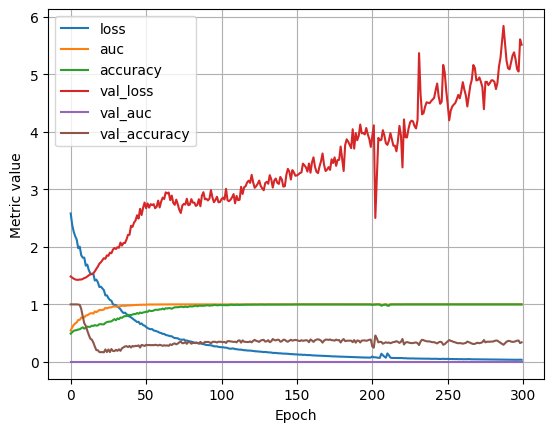

In [19]:
plots.plot_history_metrics(history)

In [24]:
metrics = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {metrics}')

16/16 - 0s - loss: 1.9012 - auc: 0.7034 - accuracy: 0.7863 - 47ms/epoch - 3ms/step
Model accuracy: [1.9011913537979126, 0.7033991813659668, 0.7862903475761414]


In [25]:
y_pred_train = model.predict(X_train)

60/60 [==============================] - 0s 2ms/step


array([[0.00652184],
       [0.00601336],
       [0.00560313],
       ...,
       [0.08231211],
       [0.10783754],
       [0.03615688]], dtype=float32)

In [27]:
y_pred = model.predict(X_test)
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 3ms/step


(496, 1)

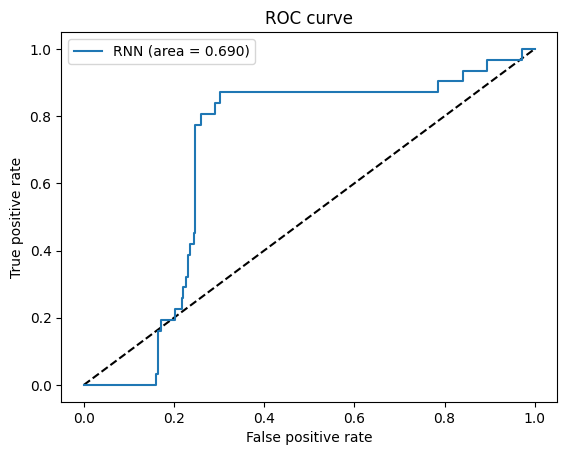

In [29]:
plots.plot_roc(y_test, y_pred)

In [32]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

metrics = model.evaluate(X_test, y_test)

print('Loss:', metrics[0])
print('Accuracy:', metrics[2])
print('Precision:', precision)
print('Recall:', recall)
print('Are these labels true???? please check')
y_test.sum(), y_pred_c.sum()


 1/16 [>.............................] - ETA: 0s - loss: 0.0377 - auc: 0.0000e+00 - accuracy: 1.0000

16/16 [==============================] - 0s 3ms/step - loss: 1.9012 - auc: 0.7034 - accuracy: 0.7863
Loss: 1.9011913537979126
Accuracy: 0.7862903475761414
Precision: 0.058823529411764705
Recall: 0.16129032258064516


(31.0, 85)

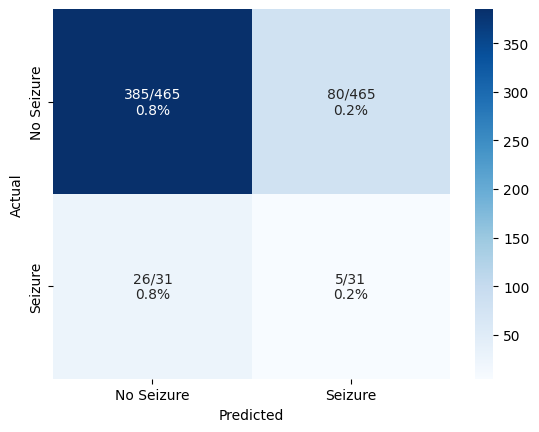

In [33]:
plots.plot_confusion_matrix(y_test, y_pred_c)

In [35]:
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       465
         1.0       0.06      0.16      0.09        31

    accuracy                           0.79       496
   macro avg       0.50      0.49      0.48       496
weighted avg       0.88      0.79      0.83       496



Text(0, 0.5, 'Predictions')

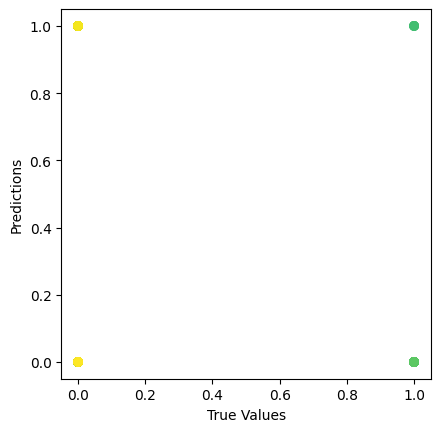

In [36]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_c,c=np.arange(len(y_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

In [41]:
# Define a sequential model
model = keras.Sequential()

#model.add(normalizer)

# Add an input layer with an input shape of (time_steps, input_features)
model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# Add a SimpleRNN layer with 32 units (neurons)
model.add(layers.SimpleRNN(72, activation='tanh'))

model.add(BatchNormalization())

# Add the output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [42]:
X_train.shape

(1891, 30, 62)

In [43]:
y_train.shape

(1891,)

In [44]:
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=300,
                    validation_data=(X_val, y_val))

NameError: name 'X_val' is not defined

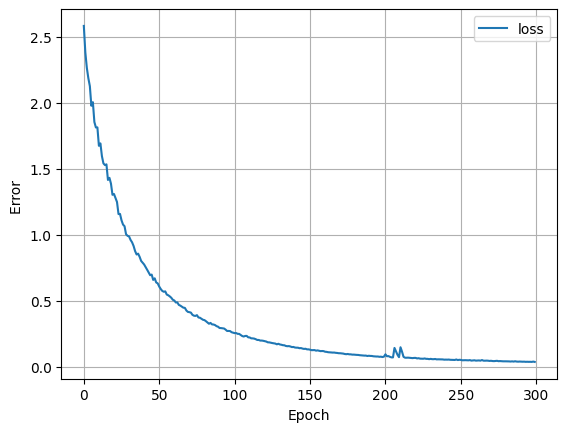

In [45]:
plot_loss(history)

In [46]:
y_pred = model.predict(X_test).flatten()
y_pred

16/16 [==============================] - 0s 2ms/step


array([0.6652413 , 0.569696  , 0.6270943 , 0.6571634 , 0.6279296 ,
       0.661146  , 0.6190019 , 0.6956031 , 0.60217565, 0.6422262 ,
       0.6130368 , 0.61739904, 0.5836438 , 0.60966194, 0.61492014,
       0.68353057, 0.62516934, 0.6223092 , 0.60138613, 0.86089545,
       0.5997883 , 0.7082959 , 0.61577535, 0.65439284, 0.6153179 ,
       0.61165124, 0.6138298 , 0.6019997 , 0.69033056, 0.5684809 ,
       0.60205024, 0.6596652 , 0.5667143 , 0.5973395 , 0.5799074 ,
       0.5978519 , 0.69248086, 0.6828316 , 0.5917969 , 0.65039593,
       0.6280549 , 0.5896513 , 0.5801114 , 0.6888158 , 0.6263854 ,
       0.5939749 , 0.6077289 , 0.7062058 , 0.5900531 , 0.61288965,
       0.6144817 , 0.6018636 , 0.6108944 , 0.6096263 , 0.6149801 ,
       0.60750127, 0.654709  , 0.6353007 , 0.60026884, 0.6303653 ,
       0.6049201 , 0.61497486, 0.57438624, 0.5701094 , 0.5770952 ,
       0.5821288 , 0.643623  , 0.621211  , 0.44605097, 0.6186412 ,
       0.5902251 , 0.7171862 , 0.6248064 , 0.6361713 , 0.63841

In [47]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

16/16 - 0s - loss: 0.6718 - accuracy: 0.5746 - 234ms/epoch - 15ms/step
Model accuracy: 0.5745967626571655


In [48]:
from sklearn.metrics import precision_score, recall_score
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

16/16 [==============================] - 0s 2ms/step - loss: 0.6718 - accuracy: 0.5746
Loss: 0.6718045473098755
Accuracy: 0.5745967626571655
Precision: 0.005494505494505495
Recall: 0.03225806451612903


(31.0, 182)

Text(0, 0.5, 'Predictions')

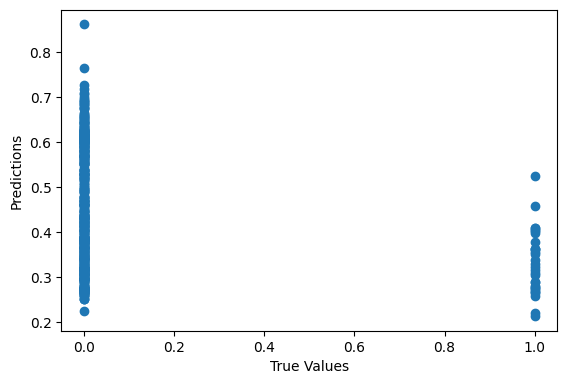

In [49]:

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')